<a href="https://colab.research.google.com/github/goransavich/cnn-xgboost/blob/main/cnn_xgboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from matplotlib import pyplot
np.random.seed(1337)  # for reproducibility
#from keras.utils import np_utils
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Convolution1D, MaxPooling1D, Flatten, Input, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
import matplotlib.pyplot as plt
from keras.regularizers import l2
from sklearn.utils import shuffle
#xgboost
import xgboost as xgb
import pandas as pd
from sklearn import metrics

In [12]:
from google.colab import files
uploaded = files.upload()
import io
import pandas as pd

train_name = list(uploaded.keys())[0]

train_df = pd.read_csv(io.BytesIO(uploaded[train_name]))

Saving FiftyWords_TRAIN.csv to FiftyWords_TRAIN (1).csv


In [13]:
uploaded = files.upload()

test_name = list(uploaded.keys())[0]

test_df = pd.read_csv(io.BytesIO(uploaded[test_name]))

Saving FiftyWords_TEST.csv to FiftyWords_TEST (1).csv


In [14]:
train_data = np.array(train_df)
test_data = np.array(test_df)
#train_data, test_data = shuffle(train_data, test_data)

In [29]:
x_train = train_data[:, :-1]
x_test = test_data[:, :-1]
train_y = train_data[:, -1:] 
test_y = test_data[:, -1:]

count_train = np.unique(train_y, return_counts=True)
count_test = np.unique(test_y, return_counts=True)

print(count_train[1])
print(count_test[1])

classes_in_dataset = len(np.unique(np.concatenate((train_y, test_y), axis=0)))

# transform the labels from integers to one hot vectors
enc = OneHotEncoder(categories='auto')
enc.fit(np.concatenate((train_y, test_y), axis=0).reshape(-1, 1))
y_train = enc.transform(train_y.reshape(-1, 1)).toarray()
y_test = enc.transform(test_y.reshape(-1, 1)).toarray()

x_train.shape
x_test.shape

[52 49 33 20 13 15 16 11 11 10 10 13 14  8  7  6  7  8  9  7  7  5  6  4
  2  6  4  6  4  6  3  7  5  3  6  6  5  4  4  4  1  2  4  6  4  4  4  5
  2  2]
[57 42 28 34 25 19 16 13 13 12 12  9  7 10  9  8  7  5  4  6  5  6  4  6
  8  4  6  3  5  3  6  2  3  5  2  2  3  4  4  4  6  5  3  1  3  3  3  2
  4  4]


(455, 270)

In [16]:
x_train,x_validate,y_train,y_validate = train_test_split(x_train,y_train,test_size = 0.1,random_state = 42)

In [34]:
if len(x_train.shape) == 2:  # if univariate
        # add a dimension to make it multivariate with one dimension 
        x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
        x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))
input_shape = x_train.shape[1:]

print(input_shape)

print(classes_in_dataset)
###y_train for xgboost without encoding
y_train_xgboost = enc.inverse_transform(y_train)


print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print(x_validate.shape)
print(y_validate.shape)

(270, 1)
50
(450, 270, 1)
(450, 50)
(455, 270, 1)
(455, 50)
(45, 270)
(45, 50)


In [39]:
inputs = input_shape
input_layer = Input(inputs)

conv2d1 = Convolution1D(filters=256, kernel_size=3, padding='valid')(input_layer)
activation1 = Activation('relu')(conv2d1)
maxpooling1 = MaxPooling1D(pool_size=2, strides=1, padding='valid')(activation1)
dropout1 = Dropout(0.1)(maxpooling1)

conv2d2 = Convolution1D(filters=128, kernel_size=3, padding='valid')(dropout1)
activation2 = Activation('relu')(conv2d2)
maxpooling2 = MaxPooling1D(pool_size=2, strides=1, padding='valid')(activation2)
dropout2 = Dropout(0.1)(maxpooling2)

flatten = Flatten()(dropout2)

dense1 = Dense(512)(flatten) ##kernel_regularizer=l2(0.001)
activation3 = Activation('relu')(dense1)

dense2 = Dense(units=classes_in_dataset)(activation3)
activation4 = Activation('softmax')(dense2)

output_for_xgboost = Model(inputs=input_layer, outputs=dense1)
model = Model(inputs=input_layer, outputs=activation4)

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

model.compile(loss ='mean_squared_error', optimizer='Adam',metrics =['accuracy'])

history = model.fit(
    x_train,
    y_train,
    batch_size=16,
    epochs=400,
    verbose=1,
    callbacks=[callback],
    validation_data=(x_validate,y_validate),
)

score = model.evaluate(x_test,y_test,verbose=0)
print('Test Loss : {:.4f}'.format(score[0]))
print('Test Accuracy : {:.4f}'.format(score[1]))


Epoch 1/400
29/29 [==============================] - 7s 232ms/step - loss: 0.0183 - accuracy: 0.2000 - val_loss: 0.0150 - val_accuracy: 0.4000
Epoch 2/400
29/29 [==============================] - 6s 223ms/step - loss: 0.0145 - accuracy: 0.4311 - val_loss: 0.0118 - val_accuracy: 0.4667
Epoch 3/400
29/29 [==============================] - 7s 226ms/step - loss: 0.0116 - accuracy: 0.5533 - val_loss: 0.0084 - val_accuracy: 0.7333
Epoch 4/400
29/29 [==============================] - 6s 223ms/step - loss: 0.0102 - accuracy: 0.6133 - val_loss: 0.0072 - val_accuracy: 0.7556
Epoch 5/400
29/29 [==============================] - 6s 223ms/step - loss: 0.0079 - accuracy: 0.6933 - val_loss: 0.0055 - val_accuracy: 0.7778
Epoch 6/400
29/29 [==============================] - 6s 223ms/step - loss: 0.0066 - accuracy: 0.7511 - val_loss: 0.0031 - val_accuracy: 0.9111
Epoch 7/400
29/29 [==============================] - 7s 225ms/step - loss: 0.0050 - accuracy: 0.8067 - val_loss: 0.0054 - val_accuracy: 0.8222

Text(0.5, 1.0, 'Train - Accuracy')

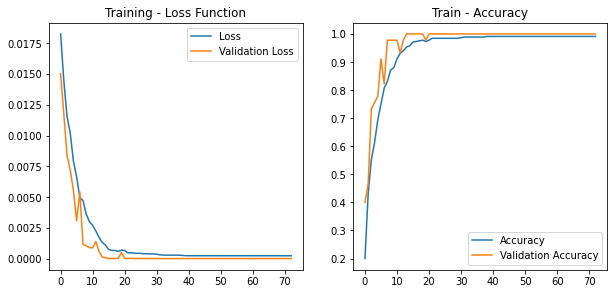

In [40]:
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function')

plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Train - Accuracy')

In [44]:
######### XGBOOST #############

intermediate_layer_model = output_for_xgboost

intermediate_layer_model.summary()

x_train_xgboost = intermediate_layer_model.predict(x_train)
x_test_xgboost = intermediate_layer_model.predict(x_test)

#label encoder for y to be in range from 0 to num-classes
def transform_labels(y_train_xgboost, test_y):
    le = preprocessing.LabelEncoder()
    y_t_xgboost = le.fit_transform(y_train_xgboost)
    t_y = le.fit_transform(test_y)
    return y_t_xgboost, t_y

y_tr_xgboost, test_y_xgboost = transform_labels(y_train_xgboost, test_y)

xgboost_train_dataset = np.concatenate([np.array(x_train_xgboost).reshape(x_train.shape[0],512),np.array(y_tr_xgboost).reshape(y_tr_xgboost.shape[0],1)],axis=1)
xgboost_train_dataset = pd.DataFrame(xgboost_train_dataset)
xgboost_train_dataset.to_csv('train_xgboost.csv',index=False)

xgboost_test_dataset = np.concatenate([np.array(x_test_xgboost).reshape(x_test.shape[0],512),np.array(test_y_xgboost).reshape(test_y_xgboost.shape[0],1)],axis=1)
xgboost_test_dataset = pd.DataFrame(xgboost_test_dataset)
xgboost_test_dataset.to_csv('test_xgboost.csv',index=False)

train = pd.read_csv('train_xgboost.csv')
train_y = train['512'].astype('int')
train_x = train.drop(['512'],axis=1)

test = pd.read_csv('test_xgboost.csv')
test_y = test['512'].astype('int')
test_x = test.drop(['512'],axis=1)

print(train_y.shape)
print(test_y.shape)

dataset = xgb.DMatrix(train_x, label=train_y)
watchlist = [(dataset, 'train')]
params = {'max_depth':6, 'eta':0.3, 'silent':1, 'num_class': classes_in_dataset} 
model_xg = xgb.train(params, dataset, num_boost_round=100)


test_x = xgb.DMatrix(test_x)
result = model_xg.predict(test_x)

Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 270, 1)]          0         
_________________________________________________________________
conv1d_51 (Conv1D)           (None, 268, 256)          1024      
_________________________________________________________________
activation_69 (Activation)   (None, 268, 256)          0         
_________________________________________________________________
max_pooling1d_51 (MaxPooling (None, 267, 256)          0         
_________________________________________________________________
dropout_50 (Dropout)         (None, 267, 256)          0         
_________________________________________________________________
conv1d_52 (Conv1D)           (None, 265, 128)          98432     
_________________________________________________________________
activation_70 (Activation)   (None, 265, 128)          0  

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(450,)
(455,)


In [45]:

from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, classification_report, confusion_matrix

#preds = model.predict(d_test)
#best_preds = np.asarray([np.argmax(line) for line in result])

print("Precision = {}".format(precision_score(test_y, result, average='macro', zero_division=0)))
print("Recall = {}".format(recall_score(test_y, result, average='macro', zero_division=0)))
print("Accuracy = {}".format(accuracy_score(test_y, result)))
print("F1 score = {}".format(f1_score(test_y, result, average='macro', zero_division=0)))

print(metrics.classification_report(test_y, result))
print(metrics.confusion_matrix(test_y, result))

Precision = 0.4724611453361453
Recall = 0.4487694959495269
Accuracy = 0.621978021978022
F1 score = 0.43035753148961187
              precision    recall  f1-score   support

           0       0.80      0.93      0.86        57
           1       0.70      0.90      0.79        42
           2       0.67      0.79      0.72        28
           3       0.72      0.68      0.70        34
           4       0.73      0.76      0.75        25
           5       0.83      0.53      0.65        19
           6       0.94      0.94      0.94        16
           7       0.77      0.77      0.77        13
           8       0.90      0.69      0.78        13
           9       0.50      0.83      0.62        12
          10       0.58      0.58      0.58        12
          11       0.29      0.44      0.35         9
          12       0.21      0.43      0.29         7
          13       0.57      0.40      0.47        10
          14       0.64      1.00      0.78         9
          15    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
